In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
plt.rcParams['figure.dpi'] = 150
%matplotlib inline
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=14)
plt.rc("legend", fontsize=14, loc="upper left")

cm = 1.5/2.54 #define ratio for cm and inches

In [12]:
Data_names = []

# Method for going through all the data we have, and it fucking works dawg
for (dir_path, dir_names, file_names) in os.walk('./Data_Labday_1'):
    for file_name in file_names:
        if file_name.endswith('.txt'): #ensures we grab only the files ending with .txt
            Data_names.append(os.path.join(dir_path, file_name))

In [26]:
time = [] #array for all time data lists
V1 = [] #Same again for votlage readings

for Data_name in Data_names:
    Data = np.loadtxt(Data_name, skiprows=3)
    time.append(Data[:, 0])
    V1.append(Data[:, 1])  # Assuming V1 is in the first column
    #print(time)
    #print(V1)

In [14]:
#Here we make the functions for the fits used
#Guesses for the linear function
a_lin_guess = 1.2 
k_lin_guess = 21e-8 
offset_lin_guess = 0.4
p0 = [a_lin_guess, k_lin_guess, offset_lin_guess]

frequency = (2*np.pi)/(633e-9)

#Linear fit function hoping that it works on a linear fit
def Linear_fit(t, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    return amplitude *(np.cos(frequency*2*k*t)) + offset

#Guesses for the quadratic fit
a_quad_guess = 2
k_quad_guess = 21e-9
offset_quad_guess = 0.4
n_quad_guess = 0
p0_NEG = [a_quad_guess, k_quad_guess, offset_quad_guess, n_quad_guess]

#Quadratic fit function if it works like this
def Quad_fit(t, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    n = p[3]
    return amplitude *(np.cos(frequency*2*(k*t**2+n*t))) + offset

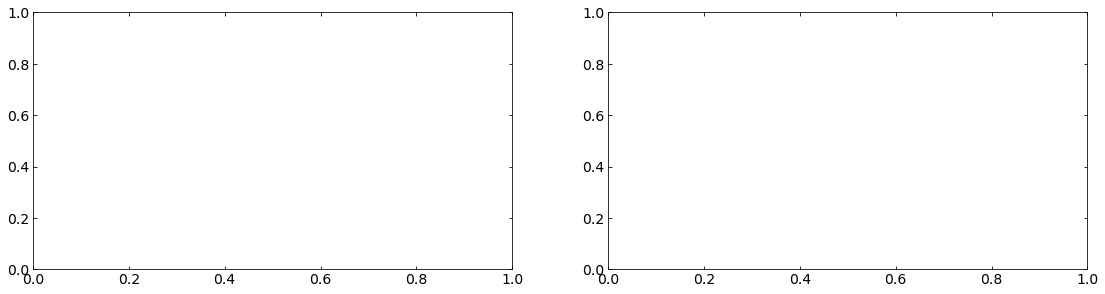

In [23]:
#Here using subplots to get 6 graphs for each iteration together.
fig, axes = plt.subplots(1,2, figsize=(32*cm,8*cm)) #figure done in inches, use this to choose a good scale
axes = axes.flatten() #Means we can iterate over it

#Here is my loop where i plot for curve fits with different powers.
for i in range(len()):
    plt.sca(axes[i])
    
    popt, pcov = sc.curve_fit(poly2, t, y, p0=np.ones(i+1),sigma=ye, absolute_sigma=True)
    plt.plot(xhelp, poly2(xhelp, *popt), 'k-', label = f"Poly-order {i}")
    plt.xlabel('Cosinus to the spreading angle')
    plt.ylabel('measured numbers')
    plt.title(f"Curve fit to the power of {i}")
    plt.legend()
    plt.grid()
    chim = np.sum(((y-poly2(t, *popt[:i+1]))/ye)**2)
    ndf = 10 -(i+1)
    p = ss.chi2.sf(chim,ndf)
    print(f"Chi min value to power of {n[i]} = {chim:.3g}", "Degress of freedom =",ndf, f"p-value = {p: 0.2g}")
    
plt.tight_layout()
plt.show()